### Import Dependencies

In [3]:
import pickle
import numpy as np  
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score

### Load Preprocessd Data

In [11]:
df.dtypes

department         int64
promoted           int64
review           float64
projects           int64
salary             int64
tenure           float64
satisfaction     float64
bonus              int64
avg_hrs_month    float64
left               int64
dtype: object

In [5]:
# Load preprocesind data
df = pd.read_csv("../data/preprocessed_data.csv")
# Show datafrma e head
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,6,0,0.577569,3,1,5.0,0.626759,0,180.866070,0
1,6,0,0.751900,3,2,6.0,0.443679,0,182.708149,0
2,9,0,0.722548,3,2,6.0,0.446823,0,184.416084,0
3,4,0,0.675158,4,0,8.0,0.440139,0,188.707545,0
4,8,0,0.676203,3,0,5.0,0.577607,1,179.821083,0


### Model Devloppment 
In this stage, five machine learning models will be trained and tested. Namely, Logistic Regression (LogReg), K-Nearest Nieghbors Classifier (KNN) , Random Forest Classifier (RFC), Spport Vector Machines (SVM), and Gradient Boosting Classifier (GBC). All the models are trained and fine-tuned using  hyperparamaters. After the training task is done , the classifiers are then evaluated using two different metrics: accuracy score and f1 score. Based on the results, we select model with the highest accuracy score , and the highest f1 score to make predictions on unseen data. 

In [13]:
# Target variable
y = df.left
# Predictors  
X = df.drop('left',axis=1)
# Split data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
# Scaling data  
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models dictionary  
model_dict = {'logreg':LogisticRegression(),
              'knn': KNeighborsClassifier(n_neighbors=5,weights='uniform'),
               'rfc': RandomForestClassifier(n_estimators = 100, max_depth =10, random_state = 43),
               'gbc': GradientBoostingClassifier(n_estimators=100, max_depth=6,learning_rate=0.1),
               'svc' : SVC(C=1.0,degree=3, kernel='rbf')}                                  

# Uppercase model names 
models = [key.upper() for key in model_dict.keys()]
acc_scores = []
f1_scores  = []
# Begin Training models 
for name, model in model_dict.items():
    print("*"*30)
    print(f'Training {name.upper()} Model')
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds)
    acc_scores.append(acc)
    f1_scores.append(f1)
    print('Done.')
    
# Save the results in a dataframe 
results_df = pd.DataFrame(list(zip(models,acc_scores,f1_scores)),columns=['Model','Accuracy Score','F1 Score'])
# show the results  
results_df

******************************
Training LOGREG Model
Done.
******************************
Training KNN Model
Done.
******************************
Training RFC Model
Done.
******************************
Training GBC Model
Done.
******************************
Training SVC Model
Done.


,Model,Accuracy Score,F1 Score
0,LOGREG,0.726765,0.337288
1,KNN,0.828092,0.690176
2,RFC,0.861635,0.738095
3,GBC,0.856744,0.734112
4,SVC,0.828442,0.656403


Four machine learning were trained and tuned in order to select the best performing model. From the dataframe above, we notice that Random Forest Classifier (RFC) has the highest accuracy and f1 score. We used a feature selection technique on top of RFC model to select the most relevent features to the target variable (left). These feaures are: department, review, projects, tenure, satisfaction,  and avg_hrs_month. 

### Feature selection: which features to select for RFC Model ?
Feature selection refers to techniques that select a subset of the most relevant features (columns) for a dataset. Fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective. Some machine learning algorithms can be misled by irrelevant input features, resulting in worse predictive performance.<br>
RFE is a wrapper-type feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. This is in contrast to filter-based feature selections that score each feature and select those features with the largest (or smallest) score.Technically, RFE is a wrapper-style feature selection algorithm that also uses filter-based feature selection internally. RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.


### Feature Importance

In [17]:
# Random Forest Classifier  
rfc = RandomForestClassifier(n_estimators=100, max_depth=10)
selector = RFE(estimator=rfc, n_features_to_select=6, step=1)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)
#print the important features to select for modeling 
important_features = list(X.columns[selector.support_])
print('Important features to select are:')
print(important_features)

[ True False  True  True False  True  True False  True]
[1 4 1 1 2 1 1 3 1]
Important features to select are:
['department', 'review', 'projects', 'tenure', 'satisfaction', 'avg_hrs_month']


Let's keep only relevant features for RFC classifer to make our predictions 

In [19]:
#choose important features for RFC model 
X_important = X[important_features]
# resplit the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.3, random_state=0)
#instanciate the classifier 
rfc = RandomForestClassifier(n_estimators = 100, max_depth =10, random_state = 43)
# fit the model 
rfc.fit(X_train,y_train)
#predict 
rfc_preds = rfc.predict(X_test)
#  evaluate the model 
acc = accuracy_score(rfc_preds,y_test)
f1 = f1_score(rfc_preds,y_test)
cfm = confusion_matrix(rfc_preds,y_test)
report = classification_report (rfc_preds,y_test)

In [23]:
X_important.dtypes

department         int64
review           float64
projects           int64
tenure           float64
satisfaction     float64
avg_hrs_month    float64
dtype: object

RFC Metrics:
Accuracy Score: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      2151
           1       0.67      0.83      0.74       711

    accuracy                           0.86      2862
   macro avg       0.81      0.85      0.82      2862
weighted avg       0.87      0.86      0.86      2862

Confusion Matrix:


Text(0.5, 1.0, 'RFC Confusion Matrix')

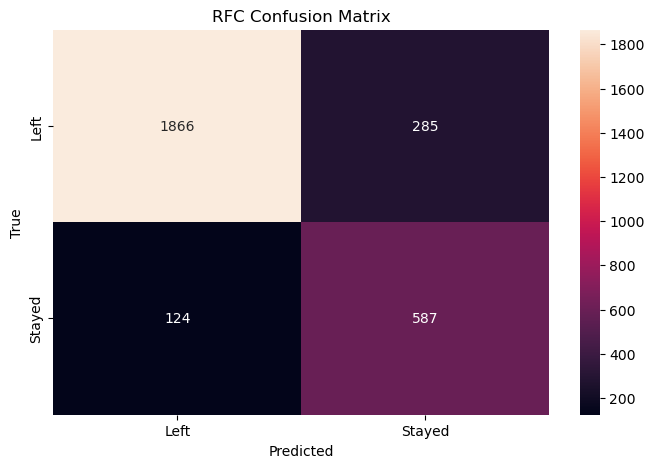

In [45]:
#show Metrics 
print('RFC Metrics:')
print(f'Accuracy Score: {round(acc,2)}')
print(f'Classification Report:\n {report}')
#plot the confusion matrix as as heatmap 
print('Confusion Matrix:')
plt.figure(figsize=(8,5))
sns.heatmap(cfm, annot=True, fmt='.0f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('RFC Confusion Matrix')

In [25]:
# Save the models 
with open('../models/RFC.pkl','wb') as file:
    pickle.dump(rfc,file)

#### Interpretation:
When an employee leaves, we ask ousevlves how often does the model predict that correctly? This measurement is called “recall” of the classifier. Based on the results above, we notice that random RFC and GBC outperformed other models in terms of recall. Out of all the turnover cases, RFC correctly retrieved 1866 out of 2151. This translates to a turnover recall of about 85% , far than other models. 
When a classifier predicts an employee will leave, how often does that employee actually leave? This measurement is called “precision”. GBC model outperformed the other models with a precision of 82%, but not far from RFC model wich has a precision scoreof 81. Both models have the same F1 score. As a result, we can choose one of the wo models to predict wether an employee will leave the company or not. Let's see if we could help with some receommandations. 

### Recommandations:
After conducting the turnover analysis based on EDA visualizations and ML methods, we saw that some feaures in the dataset seem to be very relevent to making a decision wether an employee will leave the company or stay. As result of this, we suggeste to these recommendations to reduce the rate of turnover:
1. Improve the career work of the employee by motivating him with promotions for every task or project being achieved.
2. Rewarding the employee by a bonus could motivate him to stay at the company and be productive.
3. Avoiding to overload the employees with many hours of work per month and look for other ways to raise productivity of the employee. 
4. Conducting another reviewing system that will make employees more comfortable in their departments, and motivate the ones with good scores with promotions or bonuses. 
